# Isophote Examples with the Ellipse Tool
This notebook is the first example of using Python's *photutils* Ellipse fitting tool. 

We use the example of a spiral galaxy extracted from the *F115W* filter from the cGAN network with prominent spiral arms. Note that this galaxy is not the ideal subject for science analysis by the 'ellipse' algorithm, since the algorithm assumes that the isophotes are elliptical in shape. However, this galaxy is ideal for checking the resilience of the algorithm against contamination by non-elliptical features. 

In the third notebook example, we use the ellipse fitting tool on a true elliptical galaxy.

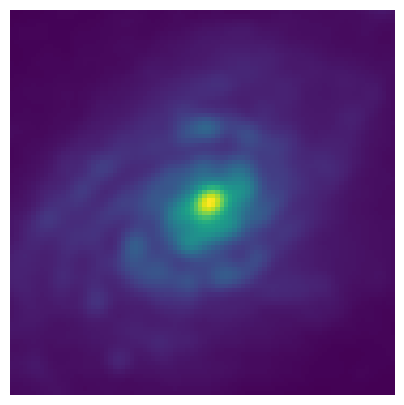

In [1]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

path = "/Users/ruby/Documents/Python Scripts/Filters/HighRes/" # use your own path to the image
hdu = fits.open(path+"F115W/47.fits")[0]
data_img = hdu.data


fig = plt.figure(figsize=(12,5))
plt.imshow(data_img)
plt.axis("off")
plt.show()

Next, we create an instance of the *Ellipse* class, passing the $2D$ numpy array with the pixel data as the argument:

In [2]:
from photutils.isophote import Ellipse

ellipse = Ellipse(data_img)

Then, we run the *fit_image* method on the above, getting an instance of the IsophoteList.

In [3]:
isolist = ellipse.fit_image()

We can display the results as an Astropy Qtable using the *to_table()* method:

In [4]:
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,0.750155432415665,0.0,0.0,0.0,0.0,0.0,0.0,None,None,46.02880311464279,0.0,44.57430008696977,0.0,1,0,0,0
0.5209868481924366,0.7491534055629431,8.459011131766387e-05,0.8745867837253944,0.010118426980508645,90.83263919192969,0.6085988012160664,-0.007133485704710272,0.005305952419884581,0.74380921747429,46.02880311464279,0.002736815242670698,44.57430008696977,0.021014567005439282,13,0,23,0
0.5730855330116803,0.7484141434310416,0.000124274536133995,0.8267478831484685,0.012424432449557132,92.13600971631095,0.7583789672344301,-0.01051121843537662,0.005850228192841813,0.5565699379961746,46.04627334698394,0.0037513772100182426,44.527919247286626,0.02055364064090311,13,0,50,2
0.6303940863128483,0.7441258274575493,0.0003901764378649415,0.5066718171040635,0.04881893613018078,98.93861469977945,3.820230044806502,-0.02218380299107508,0.011852051510046629,0.5342659919408278,46.133848854679805,0.01642264751962784,44.50597087697896,0.030939505511895643,13,0,14,0
0.6934334949441332,0.7409857405432033,0.0006250111577510486,0.3112814453102206,0.06485035754236187,107.4987155324434,7.3041746706588375,-0.03384895320302166,0.013906334146085433,0.41083498395584145,46.209855773993475,0.024216544956054603,44.492438705382604,0.03193543150489142,13,0,13,0
0.7627768444385465,0.7373764123267346,0.0007298552694910484,0.1844372483787476,0.06902446485185074,122.83217018553555,12.227419030792149,-0.040184011515225534,0.014590721383709242,0.36309768073256915,46.253426578550624,0.02878107495883119,44.498808561091394,0.030885532172333786,13,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.52271214393103,0.07443521016844003,0.0008531234798153616,0.29404175378608954,0.015310559796575716,160.1941561826128,1.7641211383629205,-0.003264322657336228,0.0003555978478677683,0.10893465052193872,39.913195237106954,0.3499478072792973,45.412394808784846,0.2878210077875318,182,0,10,0


Let's check the type of the Qtable. It should be an instance of the IsophoteList class.

In [5]:
type(isolist)

photutils.isophote.isophote.IsophoteList

### Running Ellipse for individual Isophotes
We can aldo fit individual ellipses by calling the *fit_isophote* method in the same Ellipse instance (passing the semimajor axis length as an argument where we have taken this to be $20$ pixels).

In [6]:
isophote = ellipse.fit_isophote(sma=20.)
isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20.0,0.13814963951885348,0.0016146308315591487,0.21106576984596986,0.016586127643368153,147.55615071166253,2.53625254973954,-0.011046074670899067,0.001096483984539322,0.09926458196304012,44.484247074782886,0.19531289059906712,49.428356458703455,0.18170119420194886,112,0,19,0


Note that in this case, we get an example of the Isophote class, not IsophoteList as we had before:

In [7]:
type(isophote)

photutils.isophote.isophote.Isophote

In the *photutils.isophote* package, the classes and method calls accept a variety of parameters that can be used to customise and fine-tune the fitting process. We give a few examples below. For more information, the full documentation is given here: https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html.

The fitting algorithm can be sensitive to the initial guesses of the centre positions, $x$ and $y$, of the galaxy on the frame. When using default values, such as what we did above, the method assumes that the galaxy is exactly centered which may not always be true. The fit algorithm can also fail to properly converge if either the ellipticity or the position angle of the semi-major axis are too far off the true values. To override this, we can initialise the Ellipse method with an EllipseGeometry instance. This method encapsulates the data and behaviour associated with an ellipse's geometry.

In [8]:
from photutils.isophote import EllipseGeometry

# define the geometry parameters here as an initial first guess
x0 = 45.    # center position
y0 = 45.    # center position
sma = 20.   # semimajor axis length in pixels
eps = 0.2   # ellipticity

# position angle is defined in radians, counterclockwise from the x-axis
# (rotating towards the y-axis).
pa = 35./180. * np.pi # use 35 degrees as a first guess

# initiate the Geometry instance
g = EllipseGeometry(x0, y0, sma, eps, pa)

# custom geometry is passed to the ellipse constructor
ellipse = Ellipse(data_img, geometry=g)

# make the fit
isophote = ellipse.fit_isophote(sma=20.)
print(isophote)

sma        intens             intens_err      ... nflag niter stop_code
                                              ...                      
---- ------------------ --------------------- ... ----- ----- ---------
20.0 0.1398326888913687 0.0016434492450961807 ...     0    17         0


Instead, we could use the EllipseSample and EllipseFitter methods.

Below, we initially create an instance of the EllipseSample method. This holds everything associated with a given elliptical path over the image. Not only does this include the geometry information, but also the raw intensity samples extracted from the image (intensity as a function of polar angle and radius), as well as associated statistical quantities.

The EllipseSample method allows us to override the semi-major axis length which is initially used to create the EllipseGeometry instance, such that we can propagate a given geometry configuration to other samples taken at other values of the semi-major axis length.

the EllipseSample instance is used to initialise an instance of the EllipseFitter method. This method has a number of controls to constrain the fit. The final result of the *fit* method is an instance of *Isophote* with the final fitted values of the geometry parameters.

In [9]:
from photutils.isophote import EllipseSample, EllipseFitter

sample = EllipseSample(data_img, 7., geometry=g)
fitter = EllipseFitter(sample)
isophote = fitter.fit()
print(isophote)

sma       intens           intens_err     ... nflag niter stop_code
                                          ...                      
--- ------------------ ------------------ ... ----- ----- ---------
7.0 0.4079283887212645 0.0114774129516376 ...     0     3        -1


We can access the raw values extracted from the image using the *values* attribute of the EllipseSample instance. This attribute is a $2D$ numpy array. The first element is of length $3$, and each element has as many entries as there are individual extracted values from the image.

In [10]:
isophote.sample.values.shape

(3, 32)

The top $3$-level elements contain the position angles, the polar radii and the intensity values extracted at each position along the the elliptical path on the image, respectively:

In [11]:
# angles in radians
isophote.sample.values[0]

array([0.05      , 0.19326833, 0.34208252, 0.50242004, 0.67942292,
       0.8769169 , 1.0965631 , 1.33674193, 1.59164266, 1.8514259 ,
       2.10420033, 2.33942512, 2.55096155, 2.73808387, 2.90442574,
       3.05611005, 3.20016385, 3.34358476, 3.49292957, 3.65413353,
       3.83227656, 4.03108201, 4.25204649, 4.49331832, 4.74882433,
       5.00852666, 5.26051201, 5.4944325 , 5.70447055, 5.8902073 ,
       6.05547991, 6.20650425])

In [12]:
# polar radii in pixels
isophote.sample.values[1]

array([6.97990968, 6.71978927, 6.2368435 , 5.6496254 , 5.06344545,
       4.55277637, 4.1635643 , 3.92309586, 3.84936304, 3.95609625,
       4.25125269, 4.72731803, 5.34409805, 6.01171529, 6.59263979,
       6.94185115, 6.97248393, 6.69591393, 6.20332162, 5.61346665,
       5.03004333, 4.52561431, 4.14470267, 3.91380221, 3.85056236,
       3.96848464, 4.2749568 , 4.76104217, 5.38396413, 6.0506092 ,
       6.62144933, 6.95307307])

In [13]:
# intensities
isophote.sample.values[2]

array([0.34871064, 0.34920148, 0.36710208, 0.38867613, 0.40075847,
       0.4018072 , 0.39550004, 0.39036204, 0.38507509, 0.3810873 ,
       0.37438325, 0.36481336, 0.34814193, 0.32732115, 0.31111427,
       0.31614535, 0.34435889, 0.3866287 , 0.43585366, 0.48313707,
       0.52073429, 0.54013386, 0.53902399, 0.52589829, 0.50417908,
       0.47891264, 0.45518578, 0.43891106, 0.41799304, 0.39543294,
       0.37754669, 0.35957867])

Note that in the example above, we can not use the original EllipseSample instance that was used to initialise the fitter. Once we run the fit, that instance becomes invalid and we require a new EllipseSample instance inside the Isophote instance created by the fitter.

### Plotting the Results

In [14]:
plt.rcParams['image.origin'] = 'lower'

The attributes of an Isophote instance are also the attributes of an IsophoteList instance. The difference is that, while the individual isophotes have scalar attributes, the same attributes in an IsophoteList are numpy arrays that store the given attribute across all isophotes in the list. Therefore, attributes in an IsophoteList can be directly used to make plots with matplotlib.

As an example, we can plot the magnitude as a function of (semi-major axis length)$^\frac{1}{4}$:

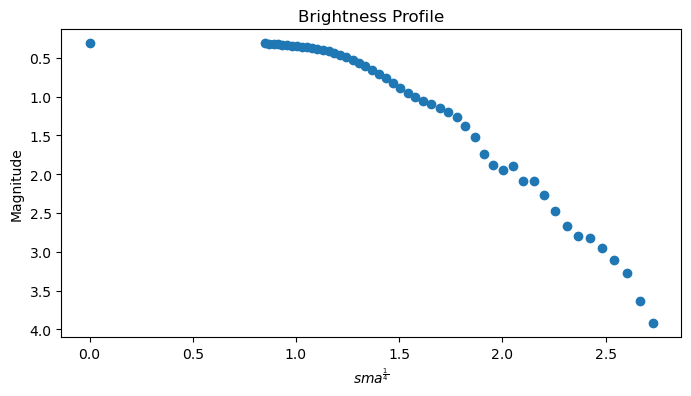

In [15]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))
plt.title('Brightness Profile')
plt.xlabel(r'$sma^\frac{1}{4}$')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

We can also plot the ellipse geometry as a function of semi-major axis length:

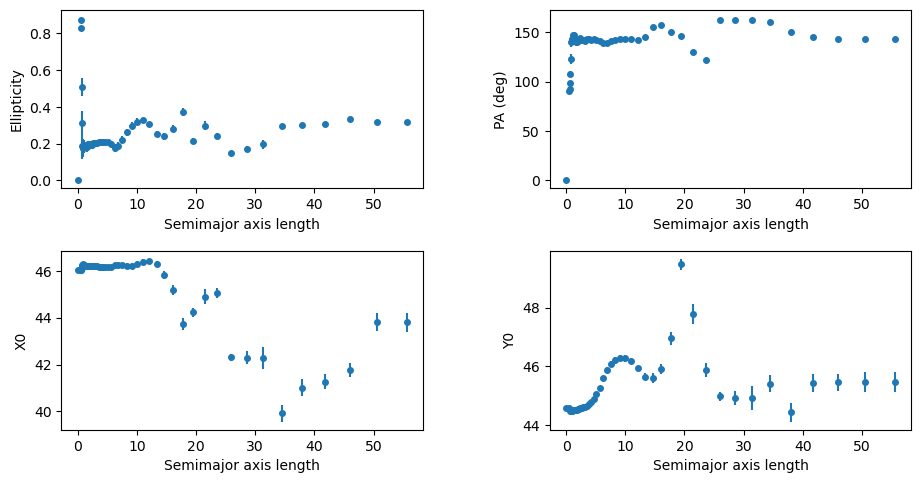

In [16]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi*80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

We can plot ellipses over the display image:

Closest SMA = 41.772482


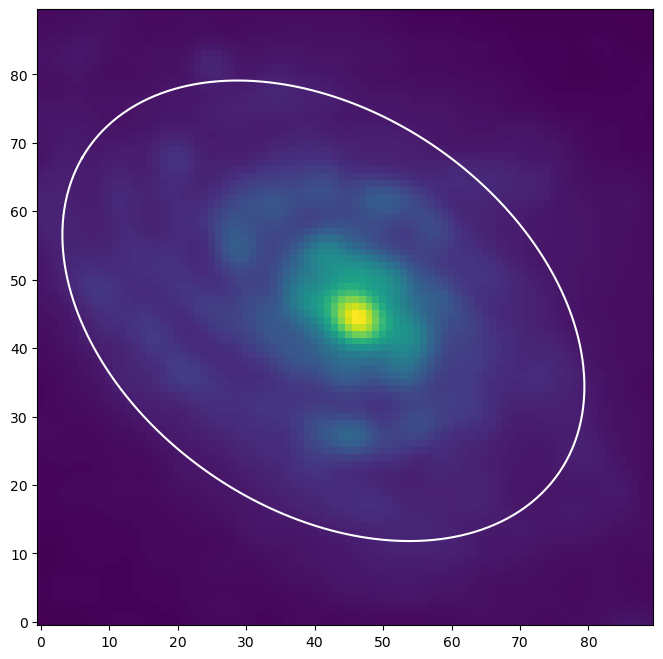

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data_img)

# this method on an IsophoteList instance will retrieve the isophote
# that has the closest 'sma' from the passed argument
iso = isolist.get_closest(40.)
print('Closest SMA = {:f}'.format(iso.sma))

# this method on an Isophote instance returns the (x, y)-coordinates
# of the sampled points in the image
x, y = iso.sampled_coordinates()
plt.plot(x, y, color='white')

However, this "isophote" doesn't quite look isophotal...
This should have been expected in this image. The fitting algorithm assumes that a smooth surface brightness distribution will dominate the image, and this is hardly the case for the galaxy we have used in this example with its prominent spiral arms. 

We can examine the elliptical brightness sample associated with the ellipse pictured above to get an idea of what is going on. The plot below shows contamination- possibly from bright $HII$ regions.

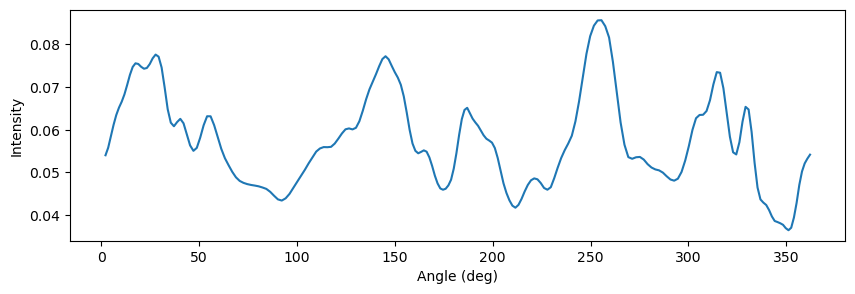

In [18]:
plt.figure(figsize=(10, 3))

plt.plot(iso.sample.values[0]/np.pi*180., iso.sample.values[2])
plt.ylabel('Intensity')
plt.xlabel('Angle (deg)')
plt.show()

We could use $\sigma$-clipping to remove this contamination. We will give an example of this in the following notebook.